In [1]:
##   Load Packages
using BayesianNonparametricStatistics, Plots
using Statistics, Distributions
using DelimitedFiles, Plots, LaTeXStrings
using NBInclude, LinearAlgebra, SparseArrays
##   Colors
lblue = RGBA(83/255, 201/255, 250/255,0.7)
dblue = RGBA(47/255, 122/255, 154/255,0.7)

In [2]:
##   Load Data
df = DelimitedFiles.readdlm("butane_data.txt", '\n',  ' ')
df = df[:,1]
#Subsampling to indexes
#X_1, X_1001, X_2001,...
indexes = [1:1000:4*10^6;]
df = df[indexes]

4000-element Vector{Float64}:
  0.099379
  0.004472
 -0.021587
  0.258075
  0.276441
  0.196464
 -0.010677
  0.154276
  0.35946
 -0.06857
  0.258267
  0.716058
 -2.305957
  ⋮
 -0.157114
  0.025924
 -0.202653
 -0.0729
  0.315765
 -1.88634
 -2.133324
 -0.989599
  0.181816
  0.02064
  0.208227
  1.935936

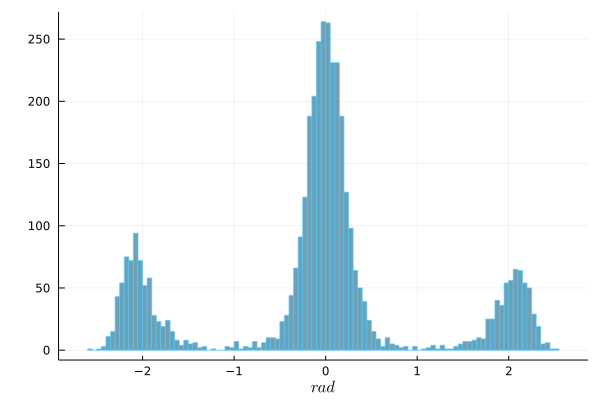

In [3]:
##   Initial Data Plots

# Plot of the time series
path_plot = plot(range(0.0,4.0, length = 4000) , df, legend = false, color = dblue)
xlabel!("\$t(ns)\$")
ylabel!("\$X_t\$")

# Histogram of angles
hist_plot = plot(df, bins = 200, seriestype = :barhist, color = dblue, legend = false, linecolor = lblue)
xlabel!("\$rad\$")
ylabel!(" ")

In [4]:
##   Define model and scale data

# Scale data to be 1-periodic
x_path = (df).+pi
x_path = (df).*1/(2*pi)

# Estimate sigma^2
# sum (v_i-v_i+1)^2
sig_est = zeros(3999)

for i in 1:3999
    sig_est[i] = (x_path[i+1]-x_path[i])^2
end
# Estimate T for unit diffusion
T = 1/sum(sig_est)

sigma_hat = sum(sig_est)/4.0

eta = 0.02*T^2*2*pi
alph = 3/2
s = 1/(sqrt(eta)*pi^2 )

# Change time scale for unit diffusion
time_t = [i*T for i in 0:3999]

x_data = SamplePath(time_t, x_path)

##   Model
#[0,4] nanoseconds
σ = 1.0/(2*pi)
beginvalue = 0.0
endtime = 3.9999#*10^-9
Δ = (4.0/4000)#*10^-9


model = SDEModel(σ, beginvalue , endtime ,  Δ)

SDEModel{Float64}(0.15915494309189535, 0.0, 3.9999, 0.001)

# Direct Computation

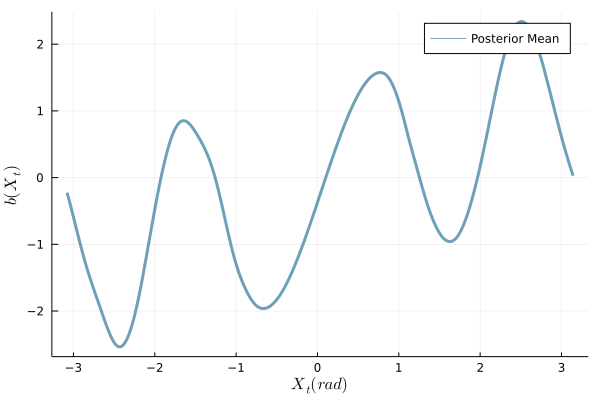

In [5]:
# Number of terms in the series
# sum_k=1^J s*k^-2*Z_k*phi_k
J = 200

# Distribution of theta in
# sum_j theta_j*phi_j
distribution = GaussianVector(diagm([(s*0.5)*k^(-alph-0.5) for k in 1.0:(J+1)]))

##   Basis functions
# Fourier
Π = GaussianProcess(vcat([x ->1.0] , [fourier(k) for k in 1:J]), distribution)


##   Posterior
postΠ = calculateposterior(Π, x_data, model)
# Posterior Mean
theta = mean(postΠ)
# x values [0,1]
x_vals = [0.01:0.001:1;]
# Plot posterior mean
bayes_post = plot(x_vals.*2*pi.-pi, theta.(x_vals), #note .*2pi to get the function on the scale of [0,2pi]
                            #instead of [0,1]
    linewidth = 3,
    linecolor = dblue,
    label = "Posterior Mean")
xlabel!("\$X_t(rad)\$")
ylabel!("\$b(X_t)\$")

In [6]:
##   Add Credible Bands
@nbinclude("Credible_Bands.ipynb")

cred_bands (generic function with 1 method)

In [7]:
#number of posterior drawings
M = 200
#alpha
alph = 0.05
#upper and lower bands
f_l,f_u =  cred_bands(M , alph , postΠ)

#x axis scale
c = 2*pi

##   Plot mean and bands

6.283185307179586

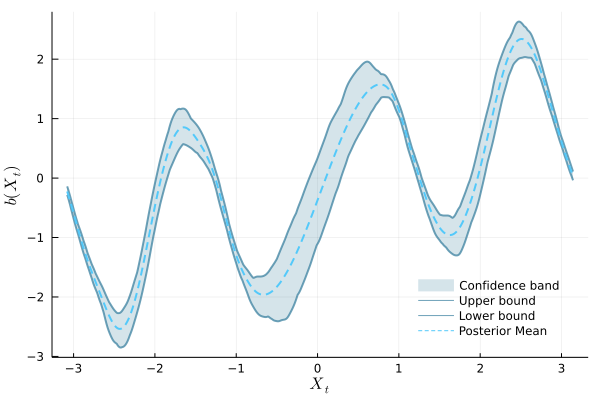

In [8]:
# Fill band color
cred_plot = plot(x_vals.*c.-pi, f_l.(x_vals), fillrange = f_u.(x_vals), fillalpha = 0.20, 
    c = dblue, label = "Confidence band", legend = :bottomright, linestyle = :dot, linealpha = 0,
foreground_color_legend = nothing,
     background_color_legend = nothing)

# Plot mean and credible bands
plot!(x_vals.*c.-pi,f_u.(x_vals), line = :solid, msw = 0, ms = 2.5, label = "Upper bound", linecolor = dblue, linewidth = 2)
plot!(x_vals.*c.-pi,f_l.(x_vals), line = :solid, msw = 0, ms = 2.5, label = "Lower bound", linecolor = dblue, linewidth = 2)
plot!(x_vals.*c.-pi, mean(postΠ).(x_vals),line = :dash, linecolor = lblue , label = "Posterior Mean", linealpha = 1, linewidth = 2)

xlabel!("\$X_t\$")
ylabel!("\$b(X_t)\$")

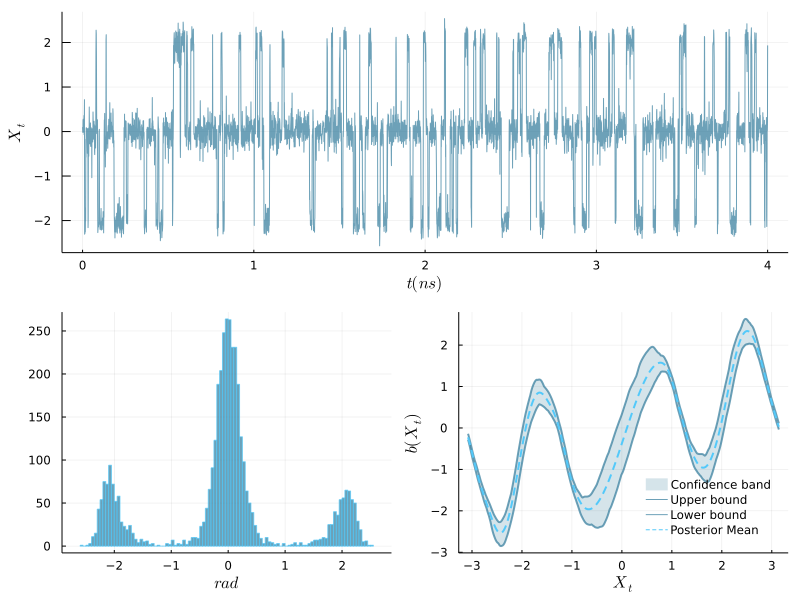

In [9]:
##   Collect in one plot
l = @layout [a ; b c]
full_bayes_plot = plot(path_plot, hist_plot, cred_plot, layout = l, size = (800,600))

# MCMC

In [10]:
@nbinclude("MCMC.ipynb")

calc_mcmc_post_drift (generic function with 1 method)

In [11]:
N_step = 5000
burn = 1000
j_max = 200

#perform MCMC
mu_lst, j_lst = mcmc(x_data, model, N_step, burn, j_max)

#calculate the posterior 
#mean vector
mcmc_post = mcmc_post_mean(mu_lst, N_step, burn)

#define the function
# sum theta_k*phi_k
mcmc_post_drift = calc_mcmc_post_drift(mcmc_post)

#11 (generic function with 1 method)

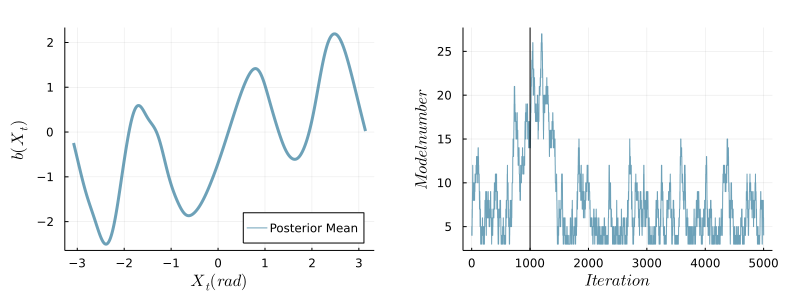

In [12]:
##   MCMC Plots

# Plot posterior mean
mcmc_post_plot = plot(x_vals.*2pi.-pi, mcmc_post_drift.(x_vals), 
    linewidth = 3,
    linecolor = dblue,
    label = "Posterior Mean",
    legend = :bottomright)
xlabel!("\$X_t(rad)\$")
ylabel!("\$b(X_t)\$")

# Plot models visited
j_lst2 = j_lst[1,:]

model_plot = plot(j_lst2, legend = false, color = dblue,)
vline!(model_plot, [1000], color = :black)
xlabel!("\$Iteration\$")
ylabel!("\$Model number\$")

##   Collect in one plot
l = @layout [a  b ]
full_mcmc_plot = plot(mcmc_post_plot,model_plot, layout = l, size = (800,300),margin=5Plots.mm)

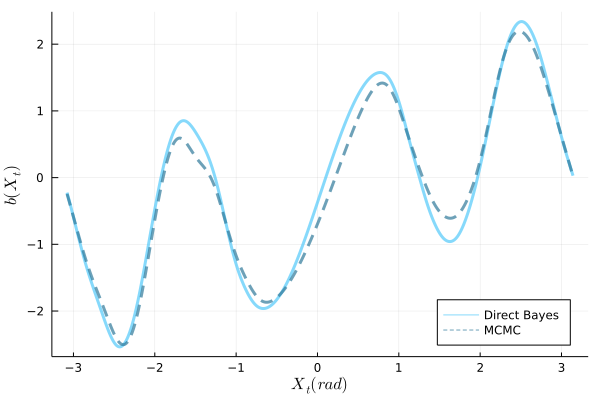

In [13]:
##   Joint plot
joint_plot = plot(x_vals.*2*pi.-pi, theta.(x_vals), #note .*2pi to get the function on the scale of [0,2pi]
                            #instead of [0,1]
    linewidth = 3,
    linecolor = lblue,
    label = "Direct Bayes")
plot!(x_vals.*2*pi.-pi, mcmc_post_drift.(x_vals),
    linewidth = 3,
    linecolor = dblue,
    linestyle = :dash,
    label = "MCMC",
    legend = :bottomright)
xlabel!("\$X_t(rad)\$")
ylabel!("\$b(X_t)\$")

In [14]:
##   Save Figures
png(full_bayes_plot, "figures\\Bayes_plot_data")
png(full_mcmc_plot, "figures\\MCMC_plot_data")
png(joint_plot, "figures\\joint_plot_data")

# Reverse plots

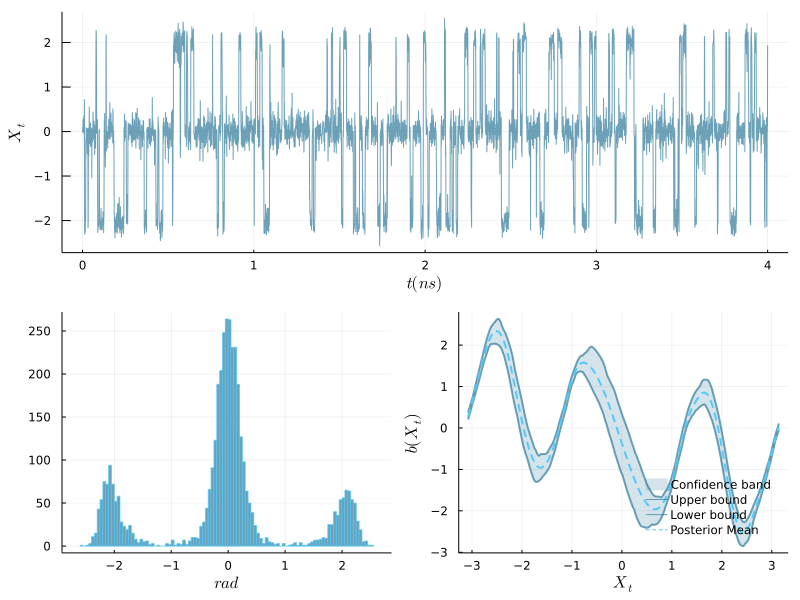

In [15]:
##   Bayes

# Fill band color
rev_cred_plot = plot(x_vals.*c.-pi, f_l.(x_vals.*(-1).+1), fillrange = f_u.(x_vals.*(-1).+1), fillalpha = 0.20, 
    c = dblue, label = "Confidence band", legend = :bottomright, linestyle = :dot, linealpha = 0,
foreground_color_legend = nothing,
     background_color_legend = nothing)

# Plot mean and credible bands
plot!(x_vals.*c.-pi,f_u.(x_vals.*(-1).+1), line = :solid, msw = 0, ms = 2.5, label = "Upper bound", linecolor = dblue, linewidth = 2)
plot!(x_vals.*c.-pi,f_l.(x_vals.*(-1).+1), line = :solid, msw = 0, ms = 2.5, label = "Lower bound", linecolor = dblue, linewidth = 2)
plot!(x_vals.*c.-pi, mean(postΠ).(x_vals.*(-1).+1),line = :dash, linecolor = lblue , label = "Posterior Mean", linealpha = 1, linewidth = 2)

xlabel!("\$X_t\$")
ylabel!("\$b(X_t)\$")

# Collect in one plot
l = @layout [a ; b c]
rev_full_bayes_plot = plot(path_plot, hist_plot, rev_cred_plot, layout = l, size = (800,600))

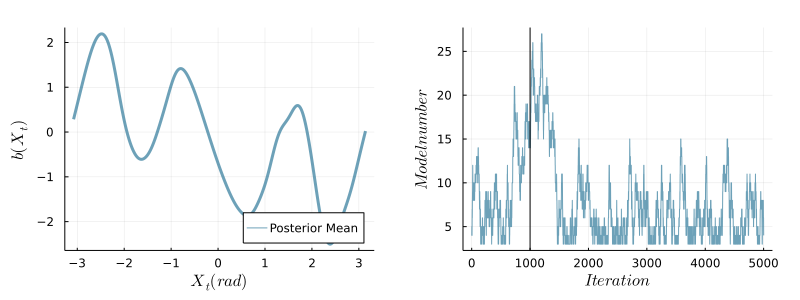

In [16]:
##   MCMC

rev_mcmc_post_plot = plot(x_vals.*2pi.-pi, mcmc_post_drift.(x_vals.*(-1).+1), 
    linewidth = 3,
    linecolor = dblue,
    label = "Posterior Mean",
    legend = :bottomright)
xlabel!("\$X_t(rad)\$")
ylabel!("\$b(X_t)\$")

# Plot models visited
j_lst2 = j_lst[1,:]

model_plot = plot(j_lst2, legend = false, color = dblue,)
vline!(model_plot, [1000], color = :black)
xlabel!("\$Iteration\$")
ylabel!("\$Model number\$")

##   Collect in one plot
l = @layout [a  b ]
rev_full_mcmc_plot = plot(rev_mcmc_post_plot,model_plot, layout = l, size = (800,300),margin=5Plots.mm)

In [17]:
##   Save Figures
png(rev_full_bayes_plot, "figures\\rev_Bayes_plot_data")
png(rev_full_mcmc_plot, "figures\\rev_MCMC_plot_data")